In [1]:
import erlyx

In [2]:
from erlyx.environment import GymAtariBWEnvironment

In [3]:
from erlyx.policies import PytorchPolicy
from erlyx.agents import BaseAgent
from erlyx.datasets import SequenceDataset
from erlyx.algorithms.ddqn import DoubleDeepQLearner

In [4]:
from erlyx.callbacks import BaseCallback
from erlyx.callbacks.recorders import TransitionRecorder, RewardRecorder
from erlyx.callbacks.updaters import OnlineUpdater, LinearEpsilonDecay
from erlyx.callbacks.checkpoint import PytorchCheckPointer

In [5]:
import numpy as np
import torch
from datetime import datetime

from collections import deque
from pathlib import Path
import os
from time import sleep

## Agent

In [6]:
class EpsilonGreedyHistoryAgent(BaseAgent):
    def __init__(self, policy, epsilon, obs_shape):
        super(EpsilonGreedyHistoryAgent, self).__init__(policy=policy)
        self.epsilon = epsilon
        self._obs_shape = obs_shape
        self._memory_buffer = deque(maxlen=4)
        
    def reset_memory(self):
        self._memory_buffer = deque([np.zeros(shape=self._obs_shape)]*4, maxlen=4)
        
    def select_action(self, observation):
        self._memory_buffer.append(observation)
        observation = np.asarray(list(self._memory_buffer))
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.action_space)
        distribution = self.policy.get_distribution(observation)
        return np.argmax(distribution)

In [7]:
class AgentMemoryReseter(BaseCallback):
    def __init__(self, agent):
        self._agent = agent
        
    def on_episode_begin(self, initial_observation):
        self._agent.reset_memory()

## Policy

In [8]:
class ConvNetwork(torch.nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self._conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1),
            torch.nn.ReLU(),
        )
        self._linear = torch.nn.Sequential(
            torch.nn.Linear(64*70, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,  18)
        )
                
    def forward(self, x):
        #if x.shape[1] != 4:
        #    raise Exception
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        output = self._conv1(x)
        output = output.view(x.shape[0], -1)
        output = self._linear(output)
        return output

In [9]:
class CNNPolicy(PytorchPolicy):
    def __init__(self):
        self._model = ConvNetwork()
        
    @property
    def model(self):
        return self._model
    
    def process_observation(self, observation):
        tensor = torch.Tensor(observation/128. - 1.)/0.35 # divided by 0.35 because of standard deviation
        return tensor
        
    def get_distribution(self, state):
        with torch.no_grad():
            self.model.eval()
            q_values = self.model(self.process_observation(state))
            distribution = torch.nn.functional.softmax(q_values, dim=1)
        return distribution.data.cpu().numpy().reshape(-1)
    
    def num_actions(self):
        return 18


# Train

In [10]:
checkpoint = torch.load('../best_checkpoint_16k.sd')

In [37]:
params = checkpoint['optimizer']['param_groups'][0]['params']

In [50]:
for param in params:
    num = checkpoint['optimizer']['state'][param]['exp_avg']
    den = checkpoint['optimizer']['state'][param]['exp_avg_sq']
    print((num/(den.sqrt() + 1e-10)).mean(), (num/(den.sqrt() + 1e-10)).std())

tensor(-0.0706) tensor(0.2181)
tensor(0.1284) tensor(0.2179)
tensor(0.0029) tensor(0.2279)
tensor(0.0047) tensor(0.2788)
tensor(0.0480) tensor(0.2241)
tensor(0.1097) tensor(0.2078)
tensor(-0.0009) tensor(0.1784)
tensor(-0.0020) tensor(0.1829)
tensor(0.0122) tensor(0.1833)
tensor(0.0752) tensor(0.2259)


In [21]:
checkpoint['model'].keys()

odict_keys(['_conv1.0.weight', '_conv1.0.bias', '_conv1.2.weight', '_conv1.2.bias', '_conv1.4.weight', '_conv1.4.bias', '_linear.0.weight', '_linear.0.bias', '_linear.2.weight', '_linear.2.bias'])

In [11]:
img_hw = (105, 80)

# policy
policy = CNNPolicy()
policy.model.load_state_dict(checkpoint['model'])

# agent
agent = EpsilonGreedyHistoryAgent(policy=policy, epsilon=0., obs_shape=img_hw)

# dataset
dataset_maxlen = 25_000
dtypes = {o: np.uint8 for o in ['state', 'action', 'reward', 'done']}
dataset = SequenceDataset(input_shape=img_hw, max_length=dataset_maxlen, history_length=4, dtypes=dtypes)

# learner
learner = DoubleDeepQLearner(32, policy, 1e-4/4, 30_000, loss_func=torch.nn.SmoothL1Loss())
learner.optimizer.load_state_dict(checkpoint['optimizer'])

In [25]:
log_folder = Path(datetime.now().strftime("%Y%m%d%H%M%S"))
os.mkdir(log_folder)
print(f'logging to folder {log_folder}')

train_callbacks = [
    # base
    AgentMemoryReseter(agent=agent),
    TransitionRecorder(dataset), 
    OnlineUpdater(learner, dataset, dataset_maxlen, 1),
    LinearEpsilonDecay(agent, 1., 0.1, 1e-6),
    # logging
    RewardRecorder(log_folder/'reward_log'),
    PytorchCheckPointer(GymAtariBWEnvironment('Seaquest-v0', simplified_reward=False), agent, 
                        learner, 25_000, dataset_maxlen, log_folder, log_folder/'checkpoint_log')
]

logging to folder 20200816231731


In [26]:
erlyx.run_steps(GymAtariBWEnvironment('Seaquest-v0'), agent, 12_000_000, train_callbacks)

KeyboardInterrupt: 

# Eval

In [47]:
env = BWGymEnvironment('Seaquest-v0', repeat=4, simplified_reward=False)
rr = RewardRecorder()
erlyx.run_episodes(env, agent, 200, [AgentMemoryReseter(agent), rr])

In [20]:
import pandas as pd

In [51]:
pd.Series(rr.rewards).describe()

count      200.000000
mean      8560.350000
std       3094.868403
min       3000.000000
25%       6487.500000
50%       8300.000000
75%      10680.000000
max      17650.000000
dtype: float64

In [48]:
np.mean(rr.rewards)

8560.35

In [21]:
import matplotlib.pyplot as plt

In [22]:
import pandas as pd

In [23]:
train_callbacks

[AgentMemoryReseter,
 TransitionRecorder,
 OnlineUpdater,
 LinearEpsilonDecay,
 RewardRecorder,
 CheckPointer]

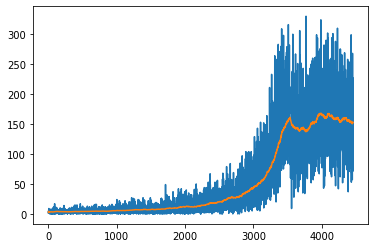

In [24]:
train_callbacks[-2].plot_rewards()
pd.Series(train_callbacks[-2].rewards).ewm(alpha=0.01).mean().plot()

In [ ]:
train_callbacks[-2].plot(0)

In [ ]:
len(dataset._memory)

In [ ]:
train_callbacks

In [ ]:
train_callbacks[-1].record[0].tolist()[0]

In [ ]:
sasa = list(map(lambda x: x.tolist()[0], train_callbacks[-1].record))

In [ ]:
sasa[

In [ ]:
pd.Series(sasa).plot()